In [3]:
import os

import numpy as np
import pandas as pd
import torch

In [4]:
%cd /workspace/EmotionShortForm/data_concatenate

/workspace/EmotionShortForm/data_concatenate


In [5]:
concatenate_vit_features = np.load('concatenate_vit_features_array.npy', allow_pickle=True)
concatenate_audio_features = np.load('concatenate_features_array.npy', allow_pickle=True)
labels = np.load('labels.npy', allow_pickle=True)

In [6]:
print(concatenate_vit_features.shape)
print(concatenate_audio_features.shape)

(556,)
(556,)


In [7]:
print(concatenate_vit_features[64].shape)
print(concatenate_audio_features[64].shape)

torch.Size([250, 768])
torch.Size([250, 128])


In [8]:
features_concatenate_list = []
cnt = 0
max_seq_len = 896
for vit_features, audio_features in zip(concatenate_vit_features, concatenate_audio_features):
    if len(vit_features.cuda()) == len(audio_features):
        concated_feature = torch.cat((vit_features.cuda(), audio_features), dim=1)
    elif len(vit_features.cuda()) > len(audio_features):
        # Split into columns of size 2
        pad = torch.zeros((len(vit_features.cuda())-len(audio_features), 128))
        audio_features = torch.cat((audio_features, pad), dim=0)
        concated_feature =torch.cat((vit_features.cuda(), audio_features), dim=1)
        print(f'check1: {concated_feature.shape}')
    elif len(vit_features.cuda()) < len(audio_features):
        pad = torch.zeros((len(audio_features)-len(vit_features.cuda()), 768))
        vit_features = torch.cat((vit_features.cuda(), pad.cuda()), dim=0)
        concated_feature =torch.cat((vit_features.cuda(), audio_features), dim=1)
        print(f'check2: {concated_feature.shape}')
    features_concatenate_list.append(concated_feature)

check2: torch.Size([224, 896])
check2: torch.Size([85, 896])
check2: torch.Size([88, 896])
check2: torch.Size([75, 896])
check2: torch.Size([202, 896])
check2: torch.Size([245, 896])


In [9]:
len(features_concatenate_list),features_concatenate_list[0].shape

(556, torch.Size([250, 896]))

In [10]:
labels.shape

(556,)

# Dataset, DataLoader

In [11]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], torch.tensor(self.labels[idx])

In [13]:
# Create an instance of dataset
md = MyDataset(features_concatenate_list,labels)

In [14]:
# train, test split
train_idx, val_idx = train_test_split(range(len(md)), test_size=0.2)

In [15]:
print(len(train_idx))
print(len(val_idx))

444
112


In [16]:
train_dataset = torch.utils.data.Subset(md, train_idx)
train_dataloader = DataLoader(train_dataset)

val_dataset = torch.utils.data.Subset(md, val_idx)
val_dataloader = DataLoader(val_dataset)

# Model

In [17]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        output = self.sigmoid(out)
        
        return output, out


# Training

In [18]:
num_epochs = 500
learning_rate = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size = 896
hidden_size = 128
num_layers = 3
output_size = 1

model = LSTMClassifier(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #SGD(model.parameters(), learning_rate,momentum=0.9,weight_decay=1e-4) 

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.total = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.total += val * n
        self.count += n
        self.avg = self.total / self.count
        
# def fmeasure(output, target):
#     _, pred = torch.tensor(output).topk(1, 1, True, True)
#     pred = pred.view(-1,1)
#     target = target.view(-1,1)
      
    
#     #overlap = ((pred== 1) + (target == 1)).gt(1)
#     #overlap = overlap.view(-1,1)
   
#     TP = len(np.where((pred==1)&(target==1)==True)[0]) # True positive
#     FP = len(np.where((pred==1)&(target==0)==True)[0]) # Condition positive = TP + FN
#     TN = len(np.where((pred==0)&(target==0)==True)[0])
#     FN = len(np.where((pred==0)&(target==1)==True)[0])

    
#     #overlap_len = overlap.data.long().sum()
#     pred_len = pred.data.long().sum()
#     gt_len   =  target.data.long().sum()

#     return TP,FP,TN,FN,pred_len, gt_len,pred

In [20]:
def fmeasure(output, target):
    pred = torch.topk(torch.from_numpy(output), 1)[1]
    pred = pred.view(-1, 1).float()
    target = target.view(-1, 1).float()
    
    TP = torch.logical_and(pred == 1, target == 1).sum().item()
    FP = torch.logical_and(pred == 1, target == 0).sum().item()
    TN = torch.logical_and(pred == 0, target == 0).sum().item()
    FN = torch.logical_and(pred == 0, target == 1).sum().item()

    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    pred = pred.cpu().numpy()

    return TP, FP, TN, FN, pred_len, gt_len, pred

In [21]:
def fmeasure(output, target, threshold):
    pred = (output > threshold).long() # 예측값을 threshold 기준으로 0 또는 1로 바꿔줍니다.

    TP = torch.sum(torch.logical_and(pred == 1, target == 1)).item()
    FP = torch.sum(torch.logical_and(pred == 1, target == 0)).item()
    TN = torch.sum(torch.logical_and(pred == 0, target == 0)).item()
    FN = torch.sum(torch.logical_and(pred == 0, target == 1)).item()
    
    pred_len = pred.sum().item()
    gt_len = target.sum().item()

    return TP, FP, TN, FN, pred_len, gt_len, pred


In [ ]:
### train, test 나눠서 성능 측정 - f1 score

from tqdm.notebook import tqdm_notebook
# LSTM ADAM

weight_dir = '/workspace/EmotionShortForm/lstm/model/weight/'

with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
    f.write('=====lstm result=======\n')
f1_best=0
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in tqdm_notebook(train_dataloader, total=len(train_dataloader), desc='Training'):
        if inputs.shape[1]!= labels.shape[1] : continue
        
        inputs = inputs.transpose(0,1).to(device)
        labels = labels.squeeze(0).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        # print(inputs[:20])
        # print(inputs.shape)
        outputs,out = model(inputs)
        outputs = outputs.squeeze(1)
        # print()
        # print(outputs[:20])
        
        #print(f'outputs:{outputs.shape}, labels:{labels.shape}')
        
        loss = criterion(outputs, labels.float())

        # Backward and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss/len(dataloader)))
    
    model.eval()
    val_losses=AverageMeter()
    acc=0
    gt_sum=0
    tp_sum=0
    fp_sum=0
    fn_sum=0
    thres = 0.2
    acc=0
    sum=0
    pred_sum=0
    with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
        with torch.no_grad():
            for inputs, labels in tqdm_notebook(val_dataloader, total=len(val_dataloader), desc='Validation'):
                if inputs.shape[1]!= labels.shape[1] : continue
                inputs = inputs.transpose(0,1).to(device)
                labels = labels.squeeze(0).to(device)
                outputs,out = model(inputs)
                
                # print(f'outputs.shape: {outputs.shape}, labels.shape: {labels.shape}')
                
                loss=criterion(outputs.squeeze(1),labels.float())
                val_losses.update(loss,labels.size(0))
                
                TP,FP,TN,FN,pred_len, gt_len,pred=fmeasure(outputs.squeeze(1).cpu(),labels.cpu(),thres)
                # print("TP: ",TP,"FP: ", FP,"TN: ", TN,"FN", FN,pred_len, gt_len)
                tp_sum += TP
                fp_sum += FP
                fn_sum += FN
                pred_sum += pred_len
                gt_sum += gt_len
                acc=acc+TP+TN
                sum+=len(out)
            if tp_sum>0 and fp_sum>0 and fn_sum>0:
                precision = tp_sum/(tp_sum+fp_sum)
                recall = tp_sum / (tp_sum+fn_sum)
                f1 = (2*precision*recall / (precision + recall))
                accuracy=acc/sum
                print("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs, running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                f.write("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs, running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                # torch.save(model.state_dict(),'{}.pt'.format(weight_dir+str(epoch)+"_train"))
                if f1_best<f1:
                    f.write("== best epoch {} train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,precision,recall,f1))
                    torch.save(model.state_dict(),'/workspace/EmotionShortForm/lstm/model/{}.pt'.format(str(epoch)+"_best"))
                    f1_best=f1
            else:
                print("epoch  [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,0,0,0))
                f.write("epoch [{}/{}], train_loss : {} , val_loss : {},p {}, r {}, f {}\n".format(epoch+1, num_epochs,running_loss/len(train_dataloader),val_losses.avg,0,0,0))
                # torch.save(model.state_dict(),'/workspace/EmotionShortForm/lstm/model/{}.pt'.format(str(epoch)+"train"))        
        

In [ ]:
outputs

In [ ]:
fmeasure(outputs.squeeze(1).cpu(), labels.cpu(), 0.2)

In [ ]:
labels[0].shape

In [ ]:
## class weight
labels_list = [i.tolist() for i in labels]
labels_flat = sum(labels_list, [])
len(labels_flat)

In [ ]:
class_count = [len(labels_flat)-sum(labels_flat), sum(labels_flat)]
class_weight = torch.tensor([1/count for count in class_count])
criterion = nn.BCELoss(weight = class_weight)

In [ ]:
class_count, class_weight

In [22]:
model.load_state_dict(torch.load('/workspace/EmotionShortForm/lstm/model/22_best.pt'))

<All keys matched successfully>

In [25]:
from tqdm.notebook import tqdm_notebook

model.eval()
val_losses=AverageMeter()
acc=0
gt_sum=0
tp_sum=0
fp_sum=0
fn_sum=0
thres = 0.2
acc=0
sum=0
pred_sum=0
with open('/workspace/EmotionShortForm/lstm/results/train_result','a') as f:
    with torch.no_grad():
        for inputs, labels in tqdm_notebook(val_dataloader, total=len(val_dataloader), desc='Validation'):
            if inputs.shape[1]!= labels.shape[1] : continue
            inputs = inputs.transpose(0,1).to(device)
            labels = labels.squeeze(0).to(device)
            outputs,out = model(inputs)

            # print(f'outputs.shape: {outputs.shape}, labels.shape: {labels.shape}')

            loss=criterion(outputs.squeeze(1),labels.float())
            val_losses.update(loss,labels.size(0))

            TP,FP,TN,FN,pred_len, gt_len,pred=fmeasure(outputs.squeeze(1).cpu(),labels.cpu(),thres)
            # print("TP: ",TP,"FP: ", FP,"TN: ", TN,"FN", FN,pred_len, gt_len)
            tp_sum += TP
            fp_sum += FP
            fn_sum += FN
            pred_sum += pred_len
            gt_sum += gt_len
            acc=acc+TP+TN
            sum+=len(out)
        if tp_sum>0 and fp_sum>0 and fn_sum>0:
            precision = tp_sum/(tp_sum+fp_sum)
            recall = tp_sum / (tp_sum+fn_sum)
            f1 = (2*precision*recall / (precision + recall))
            accuracy=acc/sum
            print("val_loss : {},p {}, r {}, f {}\n".format(val_losses.avg,precision,recall,f1))
    


Validation:   0%|          | 0/112 [00:00<?, ?it/s]

val_loss : 0.6365801095962524,p 0.3591287409243846, r 0.9881837008161773, f 0.5268045588856057



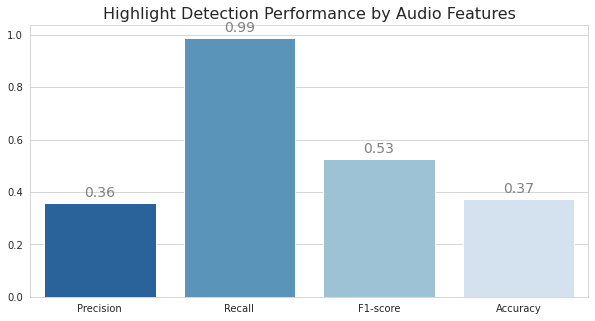

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
ax = sns.barplot(x=['Precision', 'Recall', 'F1-score', 'Accuracy'], y=[precision, recall, f1, accuracy], palette='Blues_r')
plt.title('Highlight Detection Performance by Audio Features', fontsize=16)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=14, color='gray', xytext=(0, 10), 
                textcoords='offset points')
plt.show()


# model save

In [26]:
%cd /workspace/EmotionShortForm/lstm

/workspace/EmotionShortForm/lstm


In [27]:
PATH = 'multimodal_model.pt'

# 모델 저장
torch.save(model.state_dict(), PATH)

In [36]:
!nvidia-smi

Wed Apr 19 17:58:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:65:00.0 Off |                  Off |
| 41%   31C    P8    15W / 140W |   6186MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------